In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow import keras

from sklearn.neural_network import MLPClassifier

from wordcloud import WordCloud


from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from pprint import pprint

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

import nltk 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lara\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Lara\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [6]:
data_fake = pd.read_csv("Fake.csv")
data_true = pd.read_csv("True.csv")
data_fake.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [7]:

data_fake["class"] = 0
data_true["class"] = 1

((23481, 5), (21417, 5))

In [8]:
data = pd.concat([data_fake, data_true], axis = 0)
data.columns

Index(['title', 'text', 'subject', 'date', 'class'], dtype='object')

In [9]:
df = data.drop(["title", "subject","date"], axis = 1)

In [10]:

df.isnull().sum()

text     0
class    0
dtype: int64

In [11]:

df = df.sample(frac = 1)
df.head()

,text,class
13185,Illegal aliens are killing Americans and Trump...,0
16285,WARSAW (Reuters) - Poland s political establis...,1
15693,,0
19390,BERLIN (Reuters) - Fears in Germany that vote...,1
17366,BERLIN (Reuters) - German Chancellor Angela Me...,1


In [12]:

df.reset_index(inplace = True)
df.drop(["index"], axis = 1, inplace = True)
df.columns

Index(['text', 'class'], dtype='object')

In [13]:
df.head()

,text,class
0,Illegal aliens are killing Americans and Trump...,0
1,WARSAW (Reuters) - Poland s political establis...,1
2,,0
3,BERLIN (Reuters) - Fears in Germany that vote...,1
4,BERLIN (Reuters) - German Chancellor Angela Me...,1


0    23481
1    21417
Name: class, dtype: int64
0    0.522985
1    0.477015
Name: class, dtype: float64


c:\Users\Lara\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


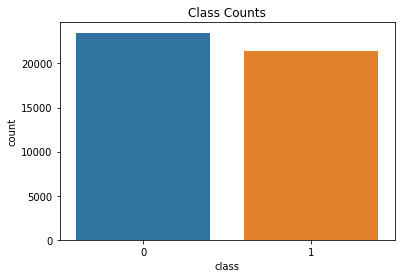

In [14]:

print(df['class'].value_counts())


print(df['class'].value_counts(normalize=True))


sns.countplot(df['class'])
plt.title("Class Counts")
plt.show()

class
0    423.197905
1    385.640099
Name: word_count, dtype: float64


c:\Users\Lara\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Lara\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


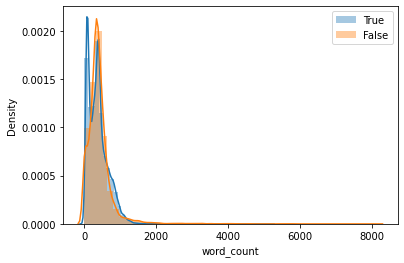

In [15]:

df['word_count'] = df['text'].str.split().str.len()


print(df.groupby('class')['word_count'].mean())


sns.distplot(df[df['class']==1]['word_count'], label='True')
sns.distplot(df[df['class']==0]['word_count'], label='False')
plt.legend()
plt.show()

In [16]:

tokenized_text = df['text'].str.lower().apply(word_tokenize)


print(tokenized_text)

0        [illegal, aliens, are, killing, americans, and...
1        [warsaw, (, reuters, ), -, poland, s, politica...
2                                                       []
3        [berlin, (, reuters, ), -, fears, in, germany,...
4        [berlin, (, reuters, ), -, german, chancellor,...
                               ...                        
44893    [rep., steve, king, (, r-ia, ), has, been, in,...
44894    [the, serious, consequences, of, political, co...
44895    [after, weeks, of, blubbering, on, twitter, an...
44896    [washington, (, reuters, ), -, the, u.s., pres...
44897    [london, (, reuters, ), -, prime, minister, th...
Name: text, Length: 44898, dtype: object


In [17]:

def alpha(tokens):
    """This function removes all non-alphanumeric characters"""
    alpha = []
    for token in tokens:
        if str.isalpha(token) or token in ['n\'t','won\'t']:
            if token=='n\'t':
                alpha.append('not')
                continue
            elif token == 'won\'t':
                alpha.append('wont')
                continue
            alpha.append(token)
    return alpha


tokenized_text = tokenized_text.apply(alpha)

print(tokenized_text)

0        [illegal, aliens, are, killing, americans, and...
1        [warsaw, reuters, poland, s, political, establ...
2                                                       []
3        [berlin, reuters, fears, in, germany, that, vo...
4        [berlin, reuters, german, chancellor, angela, ...
                               ...                        
44893    [steve, king, has, been, in, the, news, consta...
44894    [the, serious, consequences, of, political, co...
44895    [after, weeks, of, blubbering, on, twitter, an...
44896    [washington, reuters, the, presidential, race,...
44897    [london, reuters, prime, minister, theresa, ma...
Name: text, Length: 44898, dtype: object


In [18]:

def remove_stop_words(tokens):
    """This function removes all stop words in terms of nltk stopwords"""
    no_stop = []
    for token in tokens:
        if token not in stopwords.words('english'):
            no_stop.append(token)
    return no_stop


tokenized_text = tokenized_text.apply(remove_stop_words)

print(tokenized_text)

0        [illegal, aliens, killing, americans, trump, t...
1        [warsaw, reuters, poland, political, establish...
2                                                       []
3        [berlin, reuters, fears, germany, voter, apath...
4        [berlin, reuters, german, chancellor, angela, ...
                               ...                        
44893    [steve, king, news, constantly, good, recent, ...
44894    [serious, consequences, political, correctness...
44895    [weeks, blubbering, twitter, every, microphone...
44896    [washington, reuters, presidential, race, tied...
44897    [london, reuters, prime, minister, theresa, ma...
Name: text, Length: 44898, dtype: object


In [19]:

def lemmatize(tokens):
    """This function lemmatize the messages"""
    
    lemmatizer = WordNetLemmatizer()
    
    lemmatized = []
    for token in tokens:
            
            lemmatized.append(lemmatizer.lemmatize(token))
    return " ".join(lemmatized)


tokenized_text = tokenized_text.apply(lemmatize)

print(tokenized_text)

0        illegal alien killing american trump taken cau...
1        warsaw reuters poland political establishment ...
2                                                         
3        berlin reuters fear germany voter apathy could...
4        berlin reuters german chancellor angela merkel...
                               ...                        
44893    steve king news constantly good recent stunt c...
44894    serious consequence political correctness gone...
44895    week blubbering twitter every microphone could...
44896    washington reuters presidential race tied goin...
44897    london reuters prime minister theresa may told...
Name: text, Length: 44898, dtype: object


In [20]:

df['text'] = tokenized_text


display(df.head(10))

,text,class,word_count
0,illegal alien killing american trump taken cau...,0,41
1,warsaw reuters poland political establishment ...,1,352
2,,0,0
3,berlin reuters fear germany voter apathy could...,1,627
4,berlin reuters german chancellor angela merkel...,1,60
5,lucedale miss reuters mississippi vast flatlan...,1,1351
6,bernie sander pitched presidential candidate l...,0,537
7,washington reuters group senator party wednesd...,1,401
8,let say hypothetically donald trump right some...,0,383
9,johnson call obama manufactured race cop natio...,0,196


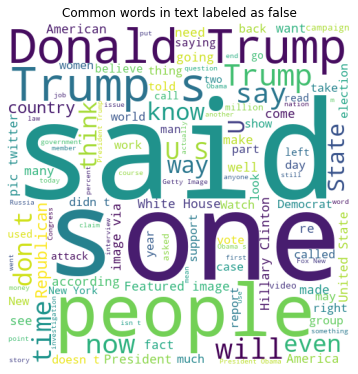

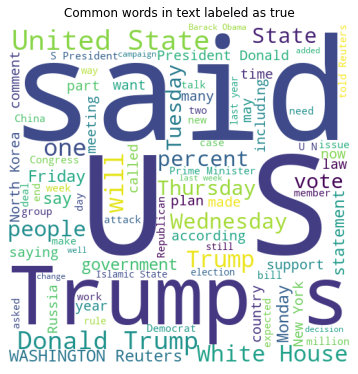

In [21]:

false = data[data['class']==0]['text'].str.cat(sep=', ')

true = data[data['class']==1]['text'].str.cat(sep=', ') 


wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color ='white')


false_wc = wc.generate(false)


plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(false_wc) 
plt.axis("off") 
plt.title("Common words in text labeled as false")
plt.tight_layout(pad = 0) 
plt.show() 

true_wc = wc.generate(true)                    
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(true_wc) 
plt.axis("off")
plt.title("Common words in text labeled as true")
plt.tight_layout(pad = 0) 
plt.show() 

In [22]:

X = data['text']
y = data['class']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34, stratify=y)

In [24]:

vectorizer = TfidfVectorizer(strip_accents='ascii')


tfidf_train = vectorizer.fit_transform(X_train)


tfidf_test = vectorizer.transform(X_test)

In [25]:

clf = MLPClassifier(activation="relu").fit(tfidf_train, y_train) 

pred = clf.predict(tfidf_test) 

print("Confusion Matrix") 
print(confusion_matrix(y_test, pred)) 
cr = classification_report(y_test,pred)
print("\n\nClassification Report\n")
print(cr)

Confusion Matrix
[[4667   29]
 [  30 4254]]


Classification Report

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [26]:

print("Accuracy: %s" % str(clf.score(tfidf_test, y_test))) 

Accuracy: 0.9934298440979955



ROC AUC Score: 0.9934108651978679


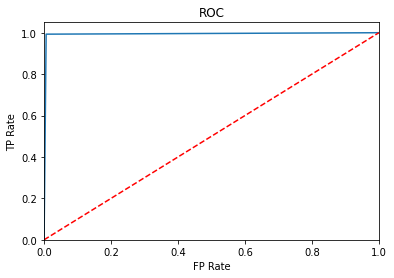

In [27]:


auc_score = roc_auc_score(y_test, pred)
print("\nROC AUC Score:",auc_score)


y_pred_proba = clf.predict(tfidf_test)


fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)


plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('ROC')
plt.show()